In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime
import time
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_folder, dataframe, transform=None):
        self.data_folder = data_folder
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.dataframe.iloc[idx, 0] + ".jpg")
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

def format_time(seconds):
    minutes, seconds = divmod(int(seconds), 60)
    hours, minutes = divmod(minutes, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [3]:
print(datetime.now())

# Vérifie si un GPU est disponible, et définit la variable device en conséquence
print("Running on GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter("logs3", comment="ResNet50")

2025-02-25 09:27:40.586702
Running on GPU: True


In [4]:
# 데이터 로드
data_folder_2020 = "/kaggle/input/isic-2020-resized/isic-2020-resized/train-resized"
label_file_2020 = "/kaggle/input/isic-2020-resized/isic-2020-resized/train-labels.csv"

data_folder_2019 = "/kaggle/input/isic-2019-resized/isic-2019-resized/train-resized"
label_file_2019 = "/kaggle/input/isic-2019-resized/isic-2019-resized/train-labels.csv"

In [5]:
# 데이터 로드
labels_2020 = pd.read_csv(label_file_2020)
labels_2019 = pd.read_csv(label_file_2019)

train_val_dataframe, test_dataframe_2020 = train_test_split(
    labels_2020, test_size=0.1, random_state=42, stratify=labels_2020['target'])  # 10% test
train_dataframe_2020, val_dataframe_2020 = train_test_split(
    train_val_dataframe, test_size=2/9, random_state=42, stratify=train_val_dataframe['target'])  # 20% validation (2/9 of 90%)

train_val_dataframe_2019, test_dataframe_2019 = train_test_split(
    labels_2019, test_size=0.1, random_state=42, stratify=labels_2019['target'])  # 10% test
train_dataframe_2019, val_dataframe_2019 = train_test_split(
    train_val_dataframe_2019, test_size=2/9, random_state=42, stratify=train_val_dataframe_2019['target'])  # 20% validation

In [6]:
# ✅ 데이터 증강 적용 (훈련 데이터에만 적용)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ✅ 검증 & 테스트 데이터는 증강 없이 기본 변환만 적용
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Train 데이터셋 생성 (2020 + 2019)
train_dataset_2020 = CustomDataset(data_folder_2020, train_dataframe_2020, train_transform)
train_dataset_2019 = CustomDataset(data_folder_2019, train_dataframe_2019, train_transform)
train_dataset = ConcatDataset([train_dataset_2020, train_dataset_2019])

# Validation 데이터셋 생성 (2020 + 2019)
val_dataset_2020 = CustomDataset(data_folder_2020, val_dataframe_2020, val_test_transform)
val_dataset_2019 = CustomDataset(data_folder_2019, val_dataframe_2019, val_test_transform)
val_dataset = ConcatDataset([val_dataset_2020, val_dataset_2019])

# Test 데이터셋 생성 (2020 + 2019)
test_dataset_2020 = CustomDataset(data_folder_2020, test_dataframe_2020, val_test_transform)
test_dataset_2019 = CustomDataset(data_folder_2019, test_dataframe_2019, val_test_transform)
test_dataset = ConcatDataset([test_dataset_2020, test_dataset_2019])

In [8]:
from torch.utils.data import WeightedRandomSampler

# ✅ WeightedRandomSampler 적용 (클래스 불균형 보정)
batch_size = 32

all_train_labels = pd.concat([train_dataframe_2020, train_dataframe_2019])['target']
class_counts = all_train_labels.value_counts()
weights = 1.0 / class_counts
sample_weights = all_train_labels.map(weights)
sampler = WeightedRandomSampler(torch.tensor(sample_weights.values, dtype=torch.float32), len(all_train_labels))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
#resnet model로 수정

model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2)  # 마지막 fully connected layer 수정
model = model.to(device)

# 하이퍼파라미터 설정
batch_size = 32
lr = 0.001
l2_reg = 0.0001
num_epochs = 20

# 손실함수 옵티마이저
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 13.0]).to(device))
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=l2_reg)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s] 


In [10]:
print(f"Total size of 2019 dataset: {len(labels_2019)} images")
print(f"Total size of 2020 dataset: {len(labels_2020)} images")

# ✅ 타겟(0과 1) 개수 출력
def count_targets(df, name):
    target_counts = df['target'].value_counts().to_dict()
    print(f"{name} dataset:")
    print(f"   - Total: {len(df)} images")
    print(f"   - Target 0: {target_counts.get(0, 0)} images")
    print(f"   - Target 1: {target_counts.get(1, 0)} images")
    print("-" * 40)

print("✅ 데이터셋 준비 완료!")
count_targets(train_dataframe_2020, "Train (2020)")
count_targets(train_dataframe_2019, "Train (2019)")
count_targets(val_dataframe_2020, "Validation (2020)")
count_targets(val_dataframe_2019, "Validation (2019)")
count_targets(test_dataframe_2020, "Test (2020)")
count_targets(test_dataframe_2019, "Test (2019)")

Total size of 2019 dataset: 4522 images
Total size of 2020 dataset: 33126 images
✅ 데이터셋 준비 완료!
Train (2020) dataset:
   - Total: 23187 images
   - Target 0: 22778 images
   - Target 1: 409 images
----------------------------------------
Train (2019) dataset:
   - Total: 3164 images
   - Target 0: 0 images
   - Target 1: 3164 images
----------------------------------------
Validation (2020) dataset:
   - Total: 6626 images
   - Target 0: 6509 images
   - Target 1: 117 images
----------------------------------------
Validation (2019) dataset:
   - Total: 905 images
   - Target 0: 0 images
   - Target 1: 905 images
----------------------------------------
Test (2020) dataset:
   - Total: 3313 images
   - Target 0: 3255 images
   - Target 1: 58 images
----------------------------------------
Test (2019) dataset:
   - Total: 453 images
   - Target 0: 0 images
   - Target 1: 453 images
----------------------------------------


In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# 최적 모델 저장을 위한 변수
best_auc = 0.0

train_losses, val_losses, train_aucs, val_aucs = [], [], [], []

print("Starting")
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    # 랜덤 샘플링된 DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)

    # Train Loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 예측값 저장
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Melanoma 확률
    
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())  # ✅ detach() 추가
    
    train_losses.append(total_loss / len(train_loader))
    train_auc = roc_auc_score(all_labels, all_probs)  # ✅ Train AUC 계산
    train_aucs.append(train_auc)  # ✅ 저장
    
    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    auc = roc_auc_score(all_labels, all_probs)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    print(f"Training - Epoch {epoch + 1}: Loss={total_loss/len(train_loader):.4f}, "
          f"Acc={accuracy:.2f}%, AUC={auc:.4f}, Precision={precision:.4f}, "
          f"Recall={recall:.4f}, F1={f1:.4f}, LR={optimizer.param_groups[0]['lr']}")

    # TensorBoard 기록
    writer.add_scalar("Training/Loss", total_loss/len(train_loader), epoch)
    writer.add_scalar("Training/Accuracy", accuracy, epoch)
    writer.add_scalar("Training/AUC", auc, epoch)
    writer.add_scalar("Training/Precision", precision, epoch)
    writer.add_scalar("Training/Recall", recall, epoch)
    writer.add_scalar("Training/F1", f1, epoch)
    writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)

    torch.save(model.state_dict(), f'ResNet50-{epoch + 1}-l2reg0.001.pth')
    #scheduler.step()
    
    # validation
    model.eval()
    total_val_loss = 0.0
    val_labels = []
    val_predictions = []
    val_probs = []

    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    # Validation Loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()
    
            # 예측값 저장
            _, predicted = torch.max(val_outputs, 1)
            probs = torch.softmax(val_outputs, dim=1)[:, 1]  # Melanoma 확률
    
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())
            val_probs.extend(probs.detach().cpu().numpy())  # ✅ detach() 추가
    
    # 성능 지표 계산
    val_accuracy = accuracy_score(val_labels, val_predictions) * 100
    val_auc = roc_auc_score(val_labels, val_probs)
    val_precision = precision_score(val_labels, val_predictions, zero_division=0)
    val_recall = recall_score(val_labels, val_predictions, zero_division=0)
    val_f1 = f1_score(val_labels, val_predictions, zero_division=0)
    #val loss, auc 저장
    val_losses.append(total_val_loss / len(val_loader))
    val_aucs.append(val_auc)  # ✅ 저장

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Validation - Epoch {epoch + 1}: Loss={total_val_loss/len(val_loader):.4f}, "
          f"Acc={val_accuracy:.2f}%, AUC={val_auc:.4f}, Precision={val_precision:.4f}, "
          f"Recall={val_recall:.4f}, F1={val_f1:.4f}")

    # TensorBoard 기록
    writer.add_scalar("Validation/Loss", total_val_loss/len(val_loader), epoch)
    writer.add_scalar("Validation/Accuracy", val_accuracy, epoch)
    writer.add_scalar("Validation/AUC", val_auc, epoch)
    writer.add_scalar("Validation/Precision", val_precision, epoch)
    writer.add_scalar("Validation/Recall", val_recall, epoch)
    writer.add_scalar("Validation/F1", val_f1, epoch)

print("Training completed!")
writer.close()

Starting
Training - Epoch 1: Loss=0.1159, Acc=72.08%, AUC=0.9649, Precision=0.6450, Recall=0.9829, F1=0.7789, LR=0.001
Validation - Epoch 1: Loss=0.5828, Acc=61.55%, AUC=0.9703, Precision=0.2585, Recall=0.9814, F1=0.4092
Training - Epoch 2: Loss=0.1037, Acc=74.70%, AUC=0.9717, Precision=0.6662, Recall=0.9853, F1=0.7949, LR=0.001
Validation - Epoch 2: Loss=0.6781, Acc=50.14%, AUC=0.9756, Precision=0.2135, Recall=0.9961, F1=0.3516
Training - Epoch 3: Loss=0.1040, Acc=75.41%, AUC=0.9729, Precision=0.6727, Recall=0.9851, F1=0.7995, LR=0.001
Validation - Epoch 3: Loss=0.5170, Acc=62.13%, AUC=0.9790, Precision=0.2626, Recall=0.9902, F1=0.4151
Training - Epoch 4: Loss=0.1018, Acc=75.65%, AUC=0.9737, Precision=0.6757, Recall=0.9854, F1=0.8017, LR=0.001
Validation - Epoch 4: Loss=0.8873, Acc=31.39%, AUC=0.9781, Precision=0.1651, Recall=1.0000, F1=0.2835
Training - Epoch 5: Loss=0.0994, Acc=75.61%, AUC=0.9750, Precision=0.6733, Recall=0.9872, F1=0.8006, LR=0.001
Validation - Epoch 5: Loss=0.5150

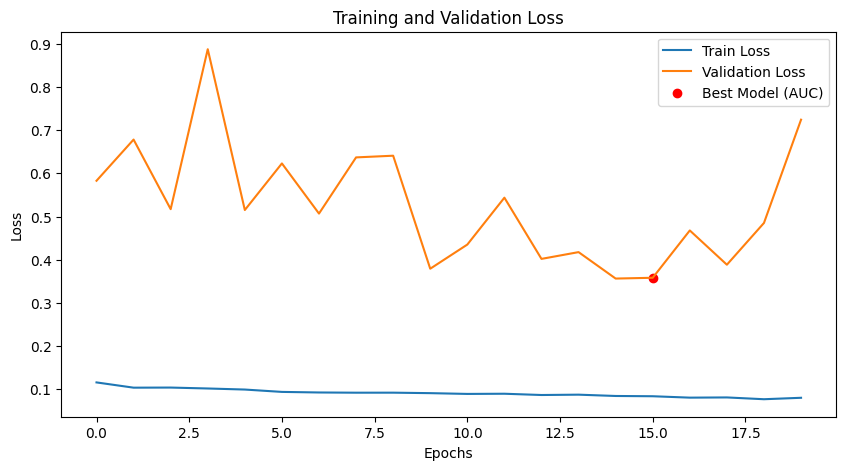

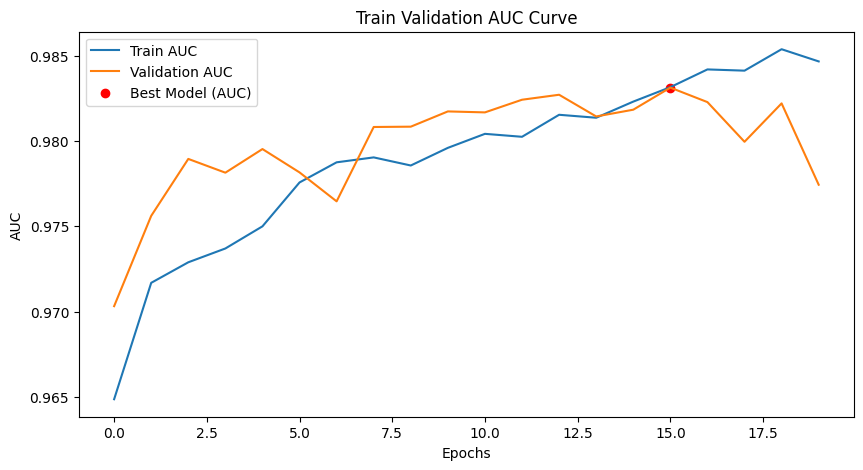

In [12]:
import matplotlib.pyplot as plt

# 🔥 최적 AUC 모델이 저장된 Epoch 찾기
best_epoch = val_aucs.index(best_auc)

# ✅ Training & Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.scatter(best_epoch, val_losses[best_epoch], color='red', marker='o', label='Best Model (AUC)')  # 🔴 추가
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# ✅ Train & Validation AUC Curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_aucs, label='Train AUC')
plt.plot(range(num_epochs), val_aucs, label='Validation AUC')
plt.scatter(best_epoch, val_aucs[best_epoch], color='red', marker='o', label='Best Model (AUC)')  # 🔴 추가
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Train Validation AUC Curve')
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# 저장된 최적 모델 로드 후 Test 평가
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
# Test 데이터 평가 루프
model.eval()
total_test_loss = 0.0
correct_test = 0
correct_test_class0 = 0
correct_test_class1 = 0
total_test = 0
total_test_class0 = 0
total_test_class1 = 0

all_test_labels = []
all_test_predictions = []
all_test_probs = []

print("\n[Start Test Evaluation]")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        test_outputs = model(inputs)
        test_loss = criterion(test_outputs, labels)
        total_test_loss += test_loss.item()

        # 예측값 저장
        _, predicted = torch.max(test_outputs, 1)
        probs = torch.softmax(test_outputs, dim=1)[:, 1]  # Melanoma 확률

        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

        for i in range(len(predicted)):
            if labels[i] == 0:
                total_test_class0 += 1
                correct_test_class0 += (predicted[i] == labels[i]).item()
            elif labels[i] == 1:
                total_test_class1 += 1
                correct_test_class1 += (predicted[i] == labels[i]).item()

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# 성능 지표 계산
test_accuracy = accuracy_score(all_test_labels, all_test_predictions) * 100
test_auc = roc_auc_score(all_test_labels, all_test_probs)
test_precision = precision_score(all_test_labels, all_test_predictions, zero_division=0)
test_recall = recall_score(all_test_labels, all_test_predictions, zero_division=0)
test_f1 = f1_score(all_test_labels, all_test_predictions, zero_division=0)

test_accuracy_class0 = correct_test_class0 / total_test_class0 * 100
test_accuracy_class1 = correct_test_class1 / total_test_class1 * 100

# 최종 Test 결과 출력
print(f"\n[Test Results]")
print(f"Loss: {total_test_loss/len(test_loader):.4f}")
print(f"Accuracy: {test_accuracy:.2f}% (Class 0: {test_accuracy_class0:.2f}%, Class 1: {test_accuracy_class1:.2f}%)")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


[Start Test Evaluation]


<ipython-input-13-6d634cda8c42>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



[Test Results]
Loss: 0.3646
Accuracy: 81.15% (Class 0: 78.71%, Class 1: 96.67%)
AUC: 0.9840
Precision: 0.4162
Recall: 0.9667
F1 Score: 0.5819



[Test Results]
Loss: 0.3646
Accuracy: 81.15% (Class 0: 78.71%, Class 1: 96.67%)
AUC: 0.9840
Precision: 0.4162
Recall: 0.9667
F1 Score: 0.5819


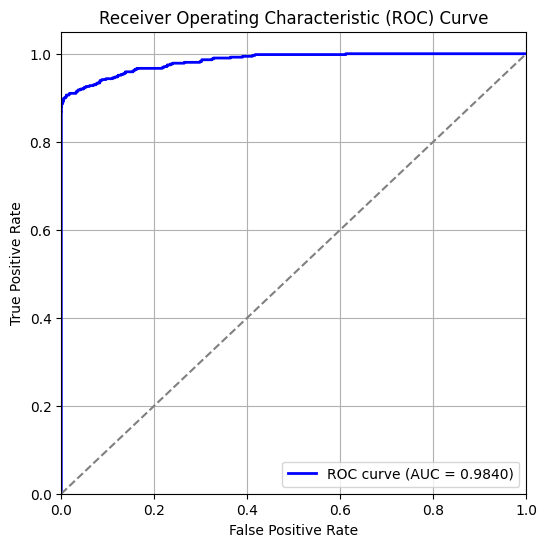

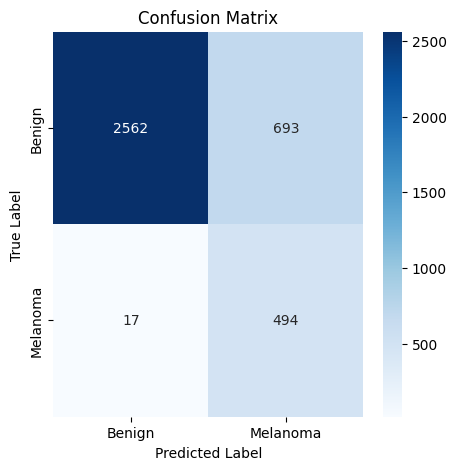

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 1️⃣ Test 결과 출력
print(f"\n[Test Results]")
print(f"Loss: {total_test_loss/len(test_loader):.4f}")
print(f"Accuracy: {test_accuracy:.2f}% (Class 0: {test_accuracy_class0:.2f}%, Class 1: {test_accuracy_class1:.2f}%)")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# 2️⃣ ROC Curve 시각화
fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 (랜덤 예측)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 3️⃣ Confusion Matrix 시각화
cm = confusion_matrix(all_test_labels, all_test_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Melanoma"], yticklabels=["Benign", "Melanoma"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()